# 每日一课 Kaggle 练习讲解

每天一道Kaggle题，学习机器学习！

今天给大家来讲讲《House Prices: Advanced Regression Techniques》（房价预测模型）的思路:
- （1） 数据可视化和数据分布变换
- （2） 缺省值处理
- （3） 数据特征变换
- （4） 数据建模及交叉检验
- （5） 模型组合

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

## 加载数据

去除ID

In [2]:
train_path = "http://kaggle.shikanon.com/house-prices-advanced-regression-techniques/train.csv"
test_path = "http://kaggle.shikanon.com/house-prices-advanced-regression-techniques/test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


我们在分析之前要先了解个字段的意思：


In [3]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

* MSSubClass: 建筑的等级，类型：类别型
* MSZoning: 区域分类，类型：类别型
* LotFrontage: 距离街道的直线距离，类型：数值型，单位：英尺
* LotArea: 地皮面积，类型：数值型，单位：平方英尺
* Street: 街道类型，类型：类别型
* Alley: 巷子类型，类型：类别型
* LotShape: 房子整体形状，类型：类别型
* LandContour: 平整度级别，类型：类别型
* Utilities: 公共设施类型，类型：类别型
* LotConfig: 房屋配置，类型：类别型
* LandSlope: 倾斜度，类型：类别型
* Neighborhood: 市区物理位置，类型：类别型
* Condition1: 主干道或者铁路便利程度，类型：类别型
* Condition2: 主干道或者铁路便利程度，类型：类别型
* BldgType: 住宅类型，类型：类别型
* HouseStyle: 住宅风格，类型：类别型
* OverallQual: 整体材料和饰面质量，类型：数值型
* OverallCond: 总体状况评价，类型：数值型
* YearBuilt: 建筑年份，类型：数值型
* YearRemodAdd: 改建年份，类型：数值型
* RoofStyle: 屋顶类型，类型：类别型
* RoofMatl: 屋顶材料，类型：类别型
* Exterior1st: 住宅外墙，类型：类别型
* Exterior2nd: 住宅外墙，类型：类别型
* MasVnrType: 砌体饰面类型，类型：类别型
* MasVnrArea: 砌体饰面面积，类型：数值型，单位：平方英尺
* ExterQual: 外部材料质量，类型：类别型
* ExterCond: 外部材料的现状，类型：类别型
* Foundation: 地基类型，类型：类别型
* BsmtQual: 地下室高度，类型：类别型
* BsmtCond: 地下室概况，类型：类别型
* BsmtExposure: 花园地下室墙，类型：类别型
* BsmtFinType1: 地下室装饰质量，类型：类别型
* BsmtFinSF1: 地下室装饰面积，类型：类别型
* BsmtFinType2: 地下室装饰质量，类型：类别型
* BsmtFinSF2: 地下室装饰面积，类型：类别型
* BsmtUnfSF: 未装饰的地下室面积，类型：数值型，单位：平方英尺
* TotalBsmtSF: 地下室总面积，类型：数值型，单位：平方英尺
* Heating: 供暖类型，类型：类别型
* HeatingQC: 供暖质量和条件，类型：类别型
* CentralAir: 中央空调状况，类型：类别型
* Electrical: 电力系统，类型：类别型
* 1stFlrSF: 首层面积，类型：数值型，单位：平方英尺
* 2ndFlrSF: 二层面积，类型：数值型，单位：平方英尺
* LowQualFinSF: 低质装饰面积，类型：数值型，单位：平方英尺
* GrLivArea: 地面以上居住面积，类型：数值型，单位：平方英尺
* BsmtFullBath: 地下室全浴室，类型：数值
* BsmtHalfBath: 地下室半浴室，类型：数值
* FullBath: 高档全浴室，类型：数值
* HalfBath: 高档半浴室，类型：数值
* BedroomAbvGr: 地下室以上的卧室数量，类型：数值
* KitchenAbvGr: 厨房数量，类型：数值
* KitchenQual: 厨房质量，类型：类别型
* TotRmsAbvGrd: 地上除卧室以外的房间数，类型：数值
* Functional: 房屋功用性评级，类型：类别型
* Fireplaces: 壁炉数量，类型：数值
* FireplaceQu: 壁炉质量，类型：类别型
* GarageType: 车库位置，类型：类别型
* GarageYrBlt: 车库建造年份，类别：数值型
* GarageFinish: 车库内饰，类型：类别型
* GarageCars: 车库车容量大小，类别：数值型
* GarageArea: 车库面积，类别：数值型，单位：平方英尺
* GarageQual: 车库质量，类型：类别型
* GarageCond: 车库条件，类型：类别型
* PavedDrive: 铺的车道情况，类型：类别型
* WoodDeckSF: 木地板面积，类型：数值型，单位：平方英尺
* OpenPorchSF: 开放式门廊区面积，类型：数值型，单位：平方英尺
* EnclosedPorch: 封闭式门廊区面积，类型：数值型，单位：平方英尺
* 3SsnPorch: 三个季节门廊面积，类型：数值型，单位：平方英尺
* ScreenPorch: 纱门门廊面积，类型：数值型，单位：平方英尺
* PoolArea: 泳池面积，类型：数值型，单位：平方英尺
* PoolQC:泳池质量，类型：类别型
* Fence: 围墙质量，类型：类别型
* MiscFeature: 其他特征，类型：类别型
* MiscVal: 其他杂项特征值，类型：类别型
* MoSold: 卖出月份，类别：数值型
* YrSold: 卖出年份，类别：数值型
* SaleType: 交易类型，类型：类别型
* SaleCondition: 交易条件，类型：类别型

## 数据处理和特征分析

In [4]:
#Saving Ids
train_ID = train_df['Id']
test_ID = test_df['Id']

#Dropping Ids
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

### 数据观察和可视化

更加常识，一般和房价最相关的是居住面积，也就是`GrLivArea`，我们查看下`GrLivArea`和`SalePrice`的关系


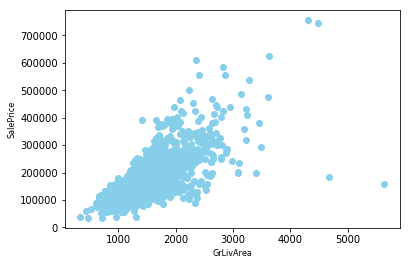

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'], c = "skyblue")
plt.ylabel('SalePrice', fontsize=8)
plt.xlabel('GrLivArea', fontsize=8)
plt.show()

我们发现有个别值特别的偏离，`GrLivArea`有两个点在4000以上，但其价格不到200000，首先这种点特别少（不到总数的3%），我们把他作为异常值去掉（其实是否去掉我们可以多做几次实验来验证）

Kaggle的作者在这里有建议去掉:)

In [6]:
train_df.drop(train_df[(train_df['GrLivArea']>4000)&(train_df['GrLivArea']<30000)].index,inplace=True)

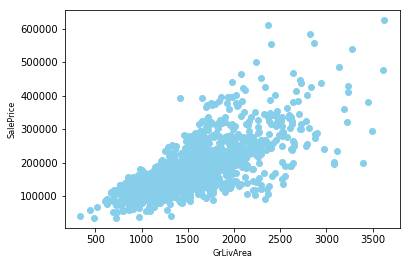

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'], c = "skyblue")
plt.ylabel('SalePrice', fontsize=8)
plt.xlabel('GrLivArea', fontsize=8)
plt.show()

* 最后一行是 `SalePrice`， 我们可以看到她跟各变量的关系，还有各变量相互之间的关系

### 观察数据分布

在机器学习中，对数据的认识是很重要的，他会影响我们的特征构建和建模，特别对于偏态分布，我们要做一些变换

In [8]:
# 统计表述
train_df['SalePrice'].describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

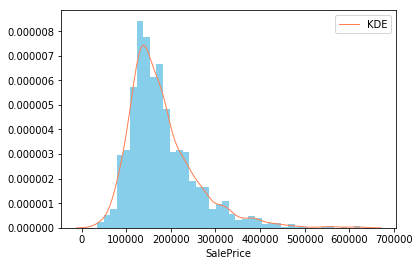

In [9]:
# 绘制分布图
sns.distplot(train_df['SalePrice'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});

Q-Q图，全称 Quantile Quantile Plot，中文名叫分位数图，Q-Q图是一个概率图，用于比较观测与预测值之间的概率分布差异，这里的比较对象一般采用正态分布，Q-Q图可以用于检验数据分布的相似性，而P-P图是根据变量的累积概率对应于所指定的理论分布累积概率绘制的散点图，两者基本一样

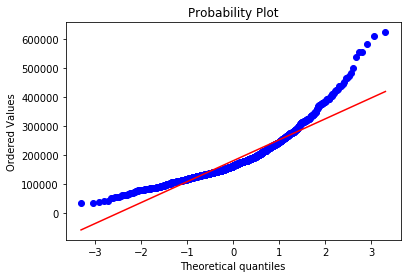

In [10]:
# 绘制P-P图
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], dist="norm", plot=plt)
plt.show()

红色线是正态分布，蓝色线是我们的数据，可以看出，我们的数据头尾都严重偏离了正太分布,我们尝试对数据做变换，常用的变换有指数变换、对数变换、幂函数等。

Skewness: 0.065449
Kurtosis: 0.666438


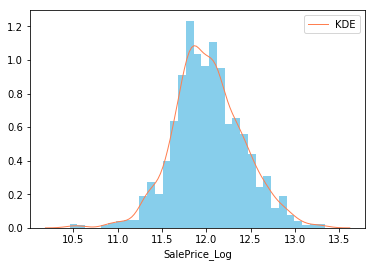

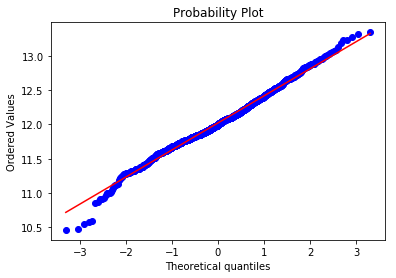

In [11]:
# 对数变换

train_df['SalePrice_Log'] = np.log(train_df['SalePrice'])

sns.distplot(train_df['SalePrice_Log'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});
 
# 偏度与峰值(skewness and kurtosis)
print("Skewness: %f" % train_df['SalePrice_Log'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log'].kurt())

fig = plt.figure()
res = stats.probplot(train_df['SalePrice_Log'], plot=plt)
plt.show()

Skewness: 6.060076
Kurtosis: 56.822460


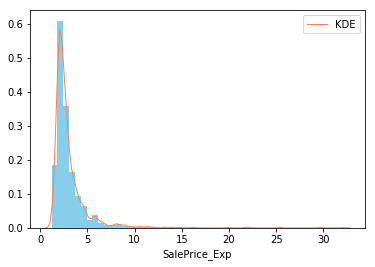

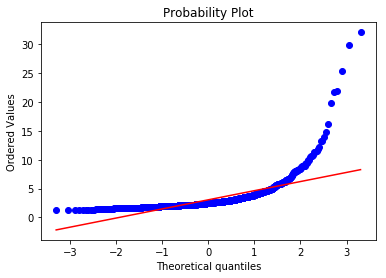

In [12]:
# 指数变换
train_df['SalePrice_Exp'] = np.exp(train_df['SalePrice']/train_df['SalePrice'].mean())

sns.distplot(train_df['SalePrice_Exp'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});
 
# 偏度与峰值(skewness and kurtosis)
print("Skewness: %f" % train_df['SalePrice_Exp'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Exp'].kurt())

fig = plt.figure()
res = stats.probplot(train_df['SalePrice_Exp'], plot=plt)
plt.show()

Skewness: 0.810797
Kurtosis: 1.245798


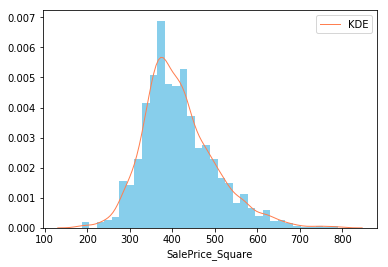

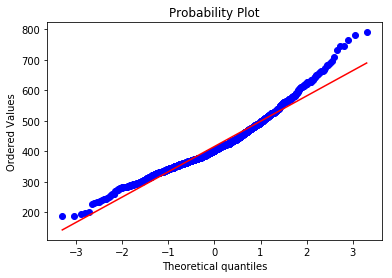

In [13]:
# 幂函数变换
train_df['SalePrice_Square'] = train_df['SalePrice']**0.5

sns.distplot(train_df['SalePrice_Square'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});
 
# 偏度与峰值(skewness and kurtosis)
print("Skewness: %f" % train_df['SalePrice_Square'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Square'].kurt())

fig = plt.figure()
res = stats.probplot(train_df['SalePrice_Square'], plot=plt)
plt.show()

三个函数拟合对比，对数转换最吻合,但是我们知道对数意味着小于1的时候为负数，这明显和认知不符合，应该采用log(1+x)，也就是log1p，保证了x数据的有效性，当x很小时,如: 10^{-16} ，由于太小超过数值有效性，用log(x+1)计算得到结果为0

Skewness: 0.065460
Kurtosis: 0.666423


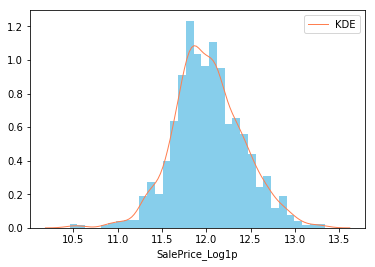

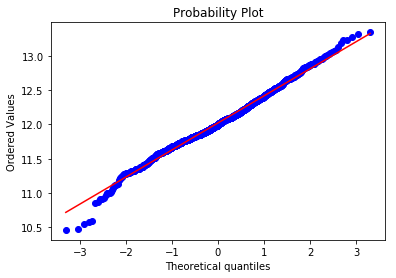

In [14]:
# 对数变换

train_df['SalePrice_Log1p'] = np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice_Log1p'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});
 
# 偏度与峰值(skewness and kurtosis)
print("Skewness: %f" % train_df['SalePrice_Log1p'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log1p'].kurt())

fig = plt.figure()
res = stats.probplot(train_df['SalePrice_Log1p'], plot=plt)
plt.show()

In [15]:
del train_df['SalePrice_Square']
del train_df["SalePrice_Exp"]
del train_df['SalePrice_Log']

In [16]:
del train_df["SalePrice"]

将测试数据和训练数据联合一起进行特征分析

In [17]:
size_train_df = train_df.shape[0]
size_test_df = test_df.shape[0]
target_variable = train_df['SalePrice_Log1p'].values
data = pd.concat((train_df, test_df),sort=False).reset_index(drop=True)
data.drop(['SalePrice_Log1p'], axis=1, inplace=True)

### 缺失值处理

缺失值是实际数据分析很重要的一块，在实际生产中一直都会有大量的缺失值存在，如何处理好缺失值是很关键也很重要的一步。

常见的缺失值处理有：
- （1）把缺失值单独作为一类，比如对类别型用none。
- （2）采用平均数、中值、众数等特定统计值来填充缺失值。
- （3）采用函数预测等方法填充缺失值。

这里的各变量填充策略：

NA for 'PoolQC' means "No Pool".

MiscFeature: NA means "None"

Alley: NA means "No alley access"

Fence: NA means "No fence"

FireplaceQu: NA means "No fireplace"

LotFrontage: fill missing values with median LotFrontage of neighborhood

GarageFinish: NA means "None"

GarageQual: NA means "None"

GarageCond: NA means "None"

GarageYrBlt: NA means 0

GarageType: NA means "None"

BsmtCond: NA means "None"

BsmtExposure: NA means "None"

BsmtQual: NA means "None"

BsmtFinType2: NA means "None"

BsmtFinType1: NA means "None"

MasVnrType: NA means "None"

MasVnrArea: NA means "0"

BsmtHalfBath: NA means "0"

BsmtFullBath: NA means "0"

BsmtFinSF1: NA means "0"

BsmtFinSF2: NA means "0"

BsmtUnfSF: NA means "0"

TotalBsmtSF: NA means "0"

GarageCars: NA means 0

GarageArea: NA means 0

In [18]:
data.count().sort_values().head(20) # 通过 count 可以找出有缺失值的数据

PoolQC             8
MiscFeature      105
Alley            198
Fence            570
FireplaceQu     1495
LotFrontage     2429
GarageCond      2756
GarageYrBlt     2756
GarageFinish    2756
GarageQual      2756
GarageType      2758
BsmtExposure    2833
BsmtCond        2833
BsmtQual        2834
BsmtFinType2    2835
BsmtFinType1    2836
MasVnrType      2891
MasVnrArea      2892
MSZoning        2911
BsmtFullBath    2913
dtype: int64

Text(0.5, 1.0, 'Percent missing data by feature')

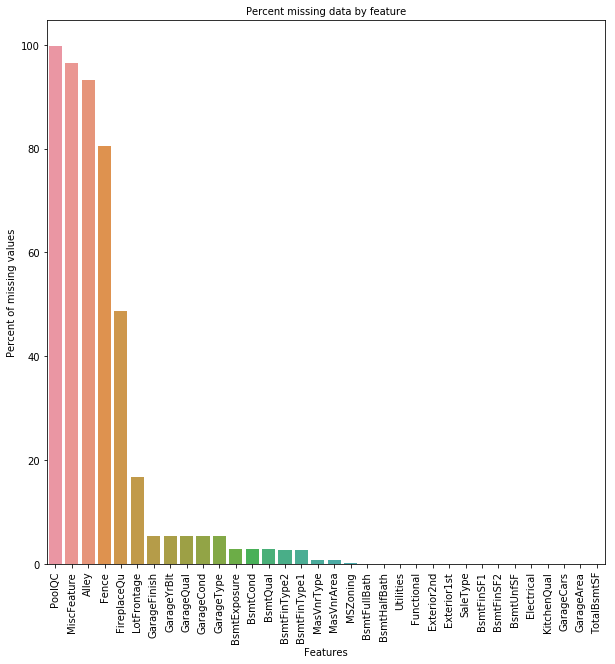

In [19]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na.drop(data_na[data_na==0].index,inplace=True)
data_na = data_na.sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10, 10))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=10)

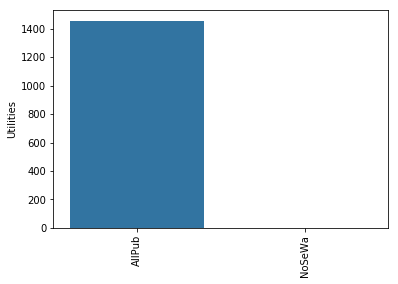

In [20]:
var = 'Utilities'
train_var_count = train_df[var].value_counts()
fig = sns.barplot(x=train_var_count.index, y=train_var_count)
plt.xticks(rotation=90);

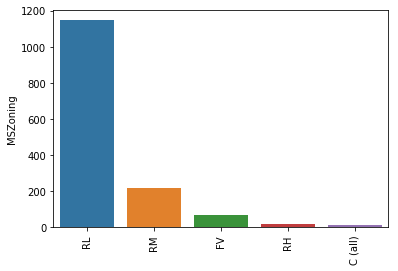

In [21]:
var = 'MSZoning'
train_var_count = train_df[var].value_counts()
fig = sns.barplot(x=train_var_count.index, y=train_var_count)
plt.xticks(rotation=90);

In [22]:
# 填充nil
features_fill_na_none = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MasVnrType']

# 填充0
features_fill_na_0 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea',
                      'BsmtFullBath','BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 
                      'BsmtUnfSF', 'TotalBsmtSF']

# 填众数
features_fill_na_mode = ["Functional", "MSZoning", "SaleType", "Electrical", 
                         "KitchenQual", "Exterior2nd", "Exterior1st"]

for feature_none in features_fill_na_none:
    data[feature_none].fillna('None',inplace=True)
    
for feature_0 in features_fill_na_0:
    data[feature_0].fillna(0,inplace=True)

for feature_mode in features_fill_na_mode:
    mode_value = data[feature_mode].value_counts().sort_values(ascending=False).index[0]
    data[features_fill_na_mode] = data[features_fill_na_mode].fillna(mode_value)

# 用中值代替
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 像 Utilities 这种总共才两个值，同时有一个值是作为主要的，这种字段是无意义的，应该删除
data.drop(['Utilities'], axis=1,inplace=True)

In [23]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na.drop(data_na[data_na==0].index,inplace=True)
data_na = data_na.sort_values(ascending=False)
data_na # data_na 为空

Series([], dtype: float64)

类型转换，将某些实际是类别类型但用数字表示的强制转换成文本，比如有些调查男表示1，女表示0，在这种情况下，如果我们直接通过dataframe类型判断会导致错误，我们要根据实际情况做转换

In [24]:
#MSSubClass=The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

### 绘制关系矩阵

关系矩阵可以很直观的告诉我们那些变量之间相关，哪些变量并不相关

In [25]:
# 关系矩阵
corrmat = train_df.corr()
corrmat

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log1p
MSSubClass,1.000000,-0.408655,-0.142192,0.032416,-0.059277,0.027689,0.040459,0.022800,-0.075268,-0.065598,...,-0.012853,-0.006687,-0.011966,-0.043802,-0.025979,0.007957,-0.007666,-0.013512,-0.021330,-0.075083
LotFrontage,-0.408655,1.000000,0.387570,0.225994,-0.055673,0.113913,0.079785,0.162026,0.133704,0.056971,...,0.077154,0.116131,0.017010,0.075575,0.047832,0.075160,0.005636,0.028042,0.010598,0.363286
LotArea,-0.142192,0.387570,1.000000,0.088719,-0.002832,0.006590,0.006930,0.081170,0.173426,0.114691,...,0.167040,0.061679,-0.016108,0.021505,0.045620,0.033875,0.039192,0.007188,-0.013014,0.258945
OverallQual,0.032416,0.225994,0.088719,1.000000,-0.090692,0.571712,0.550971,0.400028,0.213079,-0.057520,...,0.232819,0.297803,-0.112407,0.031621,0.067732,0.018121,-0.031068,0.076414,-0.024321,0.819240
OverallCond,-0.059277,-0.055673,-0.002832,-0.090692,1.000000,-0.375691,0.074703,-0.130053,-0.042542,0.040015,...,-0.003063,-0.029649,0.070103,0.025419,0.054617,0.008079,0.068729,-0.003135,0.043755,-0.036843
YearBuilt,0.027689,0.113913,0.006590,0.571712,-0.375691,1.000000,0.591906,0.314066,0.248272,-0.048393,...,0.222690,0.183905,-0.386904,0.031717,-0.049703,-0.014373,-0.034193,0.013881,-0.012593,0.588977
YearRemodAdd,0.040459,0.079785,0.006930,0.550971,0.074703,0.591906,1.000000,0.176067,0.121690,-0.067188,...,0.204020,0.222649,-0.193348,0.045596,-0.038176,-0.009490,-0.010100,0.022629,0.036597,0.568986
MasVnrArea,0.022800,0.162026,0.081170,0.400028,-0.130053,0.314066,0.176067,1.000000,0.235557,-0.071337,...,0.149491,0.106073,-0.109453,0.020270,0.065296,-0.016025,-0.029691,0.004019,-0.004880,0.430073
BsmtFinSF1,-0.075268,0.133704,0.173426,0.213079,-0.042542,0.248272,0.121690,0.235557,1.000000,-0.048738,...,0.201462,0.071851,-0.103053,0.029879,0.070026,0.016380,0.005149,-0.001773,0.018506,0.382710
BsmtFinSF2,-0.065598,0.056971,0.114691,-0.057520,0.040015,-0.048393,-0.067188,-0.071337,-0.048738,1.000000,...,0.069028,0.005083,0.036269,-0.030090,0.088676,0.053178,0.004871,-0.015726,0.031384,0.006420


In [26]:
mask = np.zeros_like(corrmat) # 返回相同大小的0矩阵
mask[np.triu_indices_from(mask)] = True # triu_indices_from: 函数的上三角矩阵
mask

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

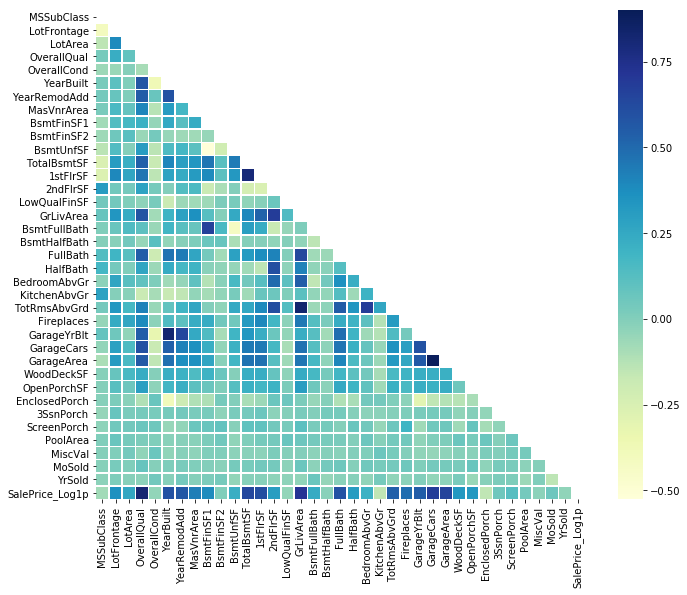

In [27]:
# 绘制热力图
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, mask=mask, linewidths=.5, vmax=0.9, square=True, cmap="YlGnBu")

## 特征工程

对数据做特征变换:

对于类别数据，一般采用`LabelEncoder`的方式，把每个类别的数据变成数值型；也可以采用`one-hot`变成稀疏矩阵

对于数值型的数据，尽量将其变为正态分布。

In [28]:
encode_cat_variables = ('Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 
                        'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 
                        'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 
                        'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 
                        'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 
                        'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'YrSold')

numerical_features = [col for col in data.columns if col not in encode_cat_variables]
# for variable in encode_cat_variables:
#     lbl = LabelEncoder() 
#     lbl.fit(list(data[variable].values)) 
#     data[variable] = lbl.transform(list(data[variable].values))

for variable in data.columns:
    if variable not in encode_cat_variables:
        data[variable] = data[variable].apply(float)
    else:
        data[variable] = data[variable].apply(str)

print(data.shape)

data = pd.get_dummies(data)
print(data.shape)

(2915, 78)
(2915, 343)


In [29]:
# 可以计算一个总面积指标
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [30]:
print("Categorical Features: %d"%len(encode_cat_variables))
print("Numerical Features: %d"%len(numerical_features))

Categorical Features: 46
Numerical Features: 32


数值型变量的分布

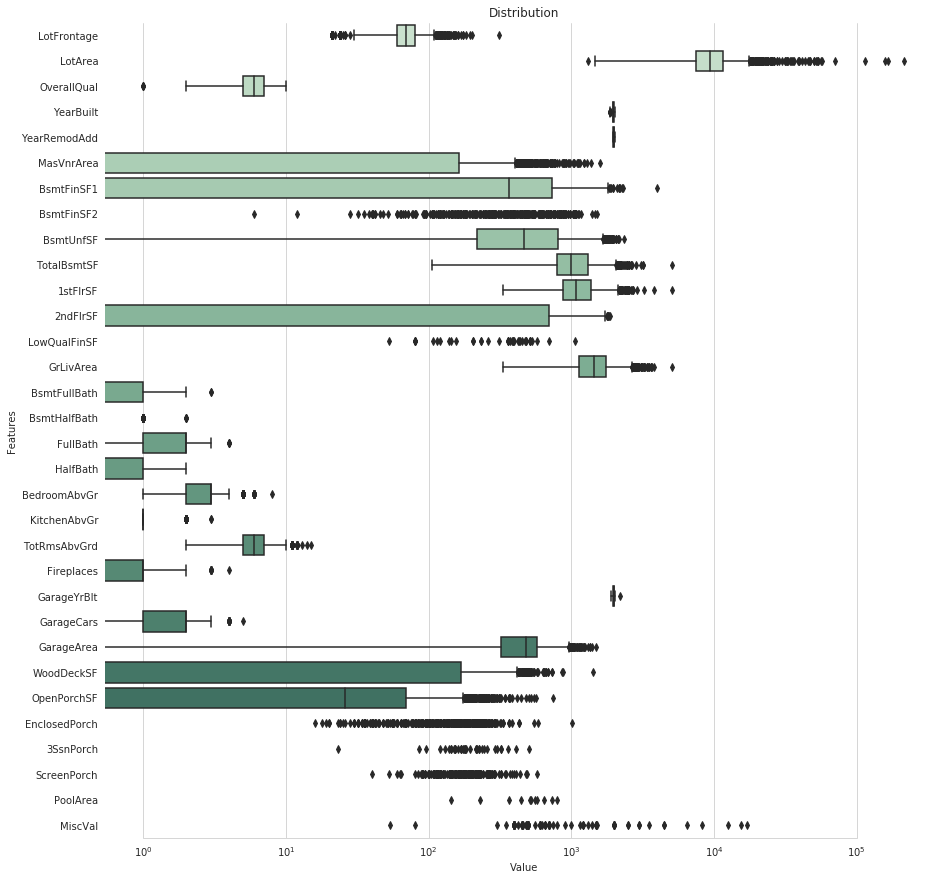

In [31]:

#Boxplot for numerical_features
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 15))
ax.set_xscale("log")
ax = sns.boxplot(data=data[numerical_features] , orient="h", palette="ch:2.5,-.2,dark=.3")
ax.set(ylabel="Features")
ax.set(xlabel="Value")
ax.set(title="Distribution")
sns.despine(trim=True, left=True)

**box-cox变换**

[Box-Cox](https://baike.baidu.com/item/box-cox%E5%8F%98%E6%8D%A2/10278422?fr=aladdin)变换是Box和Cox在1964年提出的一种广义幂变换方法，用于连续的响应变量不满足正态分布的情况。Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。Box-Cox变换的主要特点是引入一个参数，通过数据本身估计该参数进而确定应采取的数据变换形式

In [32]:
# 计算数值型变量的偏态
skewed_features = data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_features

MiscVal          21.932147
PoolArea         18.701829
LotArea          13.123758
LowQualFinSF     12.080315
3SsnPorch        11.368094
KitchenAbvGr      4.298845
BsmtFinSF2        4.142863
EnclosedPorch     4.000796
ScreenPorch       3.943508
BsmtHalfBath      3.942892
MasVnrArea        2.600697
OpenPorchSF       2.529245
WoodDeckSF        1.848285
1stFlrSF          1.253011
LotFrontage       1.092709
GrLivArea         0.977860
BsmtFinSF1        0.974138
BsmtUnfSF         0.920135
2ndFlrSF          0.843237
TotRmsAbvGrd      0.749579
Fireplaces        0.725958
HalfBath          0.698770
TotalBsmtSF       0.662657
BsmtFullBath      0.622820
BedroomAbvGr      0.328129
GarageArea        0.217748
OverallQual       0.181902
FullBath          0.159917
GarageCars       -0.219402
YearRemodAdd     -0.449113
YearBuilt        -0.598087
GarageYrBlt      -3.903046
dtype: float64

In [33]:
skewed_features = skewed_features[abs(skewed_features) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewed_features.shape[0]))

from scipy.special import boxcox1p
skewed_features_name = skewed_features.index
lam = 0.15 # 超参数
for feat in skewed_features_name:
    tranformer_feat = boxcox1p(data[feat], lam)
    data[feat] = tranformer_feat

data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

There are 20 skewed numerical features to Box Cox transform


PoolArea         16.487849
3SsnPorch         8.918476
LowQualFinSF      8.737917
MiscVal           5.592866
BsmtHalfBath      3.798589
KitchenAbvGr      3.695780
ScreenPorch       2.975708
BsmtFinSF2        2.561989
EnclosedPorch     2.023182
TotRmsAbvGrd      0.749579
Fireplaces        0.725958
HalfBath          0.698770
TotalBsmtSF       0.662657
MasVnrArea        0.636713
BsmtFullBath      0.622820
2ndFlrSF          0.329999
BedroomAbvGr      0.328129
WoodDeckSF        0.225571
GarageArea        0.217748
OverallQual       0.181902
LotArea           0.178523
1stFlrSF          0.173668
FullBath          0.159917
GrLivArea         0.102287
OpenPorchSF       0.100679
GarageCars       -0.219402
YearRemodAdd     -0.449113
BsmtFinSF1       -0.488447
YearBuilt        -0.598087
LotFrontage      -0.808022
BsmtUnfSF        -1.536727
GarageYrBlt      -3.922152
dtype: float64

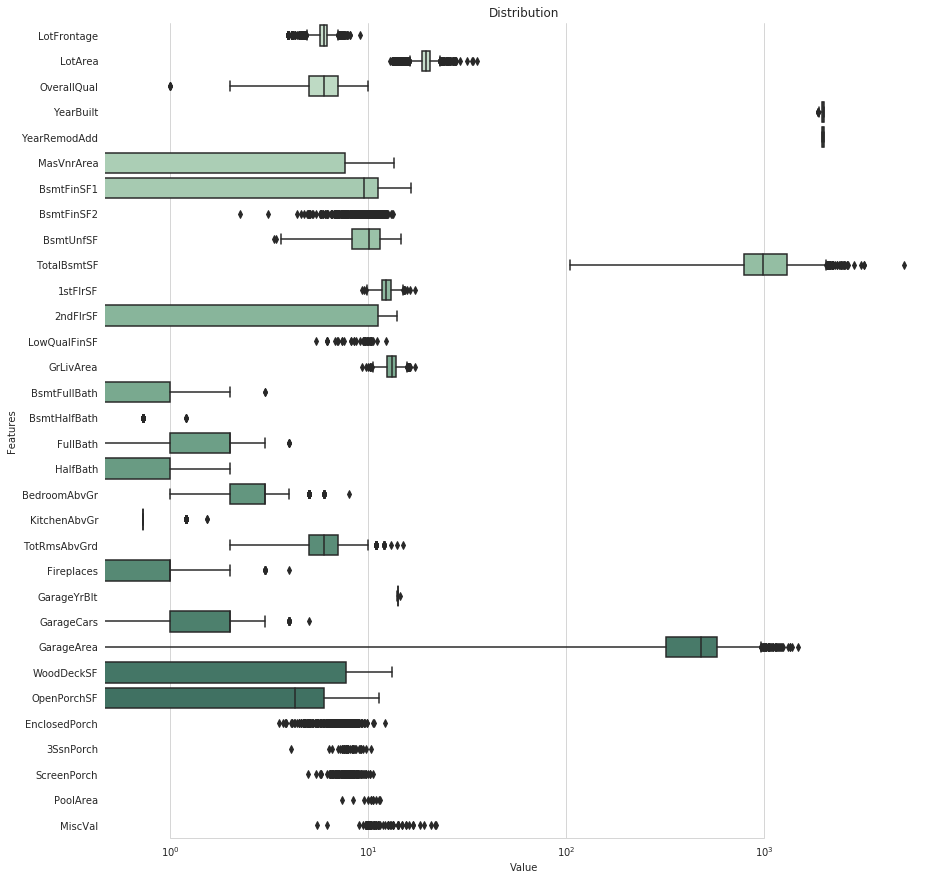

In [34]:
#Boxplot for numerical_features
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 15))
ax.set_xscale("log")
ax = sns.boxplot(data=data[numerical_features] , orient="h", palette="ch:2.5,-.2,dark=.3")
ax.set(ylabel="Features")
ax.set(xlabel="Value")
ax.set(title="Distribution")
sns.despine(trim=True, left=True)

特征处理完后可以将数据再分割开：

In [35]:
train = data[:size_train_df]
test = data[size_train_df:]

## 建模

构建算法模型，常用的几个算法模型都试试，然后设置交叉检验:


In [36]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

定义一个交叉评估函数


In [40]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target_variable, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

**LASSO回归(LASSO Regression)**

采用了*L1范数*，即绝对值之和。

*注：当数据包含许多异常值，使用均值和方差缩放可能并不是一个很好的选择。这种情况下，可以使用 `robust_scale` 以及 `RobustScaler` 作为替代品。*

In [41]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1101 (0.0058)



**岭回归（Kernel Ridge Regression）**

采用了*L2范数*，即平方和。

In [44]:
KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
score = rmsle_cv(KRR)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1152 (0.0043)



**弹性网络回归(Elastic Net Regression)**

ElasticNet 是一种使用L1和L2先验作为正则化矩阵的线性回归模型,弹性网络是结合了岭回归和Lasso回归，由两者加权平均所得。

https://www.jianshu.com/p/65a573b9fe32

In [75]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1100 (0.0059)



**组合模型**

现在常用的组合模型有提升树(Gradient Boosting Regression)、XGBoost、LightGBM 等

**提升树(Gradient Boosting Regression)**:

In [74]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

score = rmsle_cv(GBoost)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1164 (0.0082)



**XGBoost**

In [47]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1172 (0.0053)



**LightGBM**

In [48]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1162 (0.0060)



**寻找最优参数**

通过可视化的方式来看看如何寻找模型最优参数

In [68]:
alphas = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
cv_ridge_score = [rmsle_cv(make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=1))).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

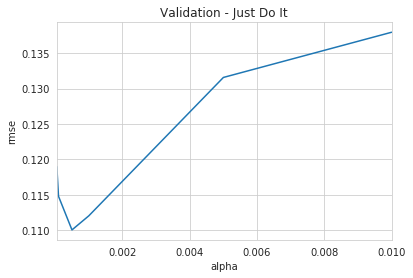

In [69]:
cv_ridge = pd.Series(cv_ridge_score, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

几个基础模型预测值的比较:

In [78]:
train_size = int(len(train)*0.7)
X_train = train.values[:train_size]
X_test = train.values[train_size:]
y_train = target_variable[:train_size]
y_test = target_variable[train_size:]

GBoost.fit(X_train, y_train)
ENet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

残差图

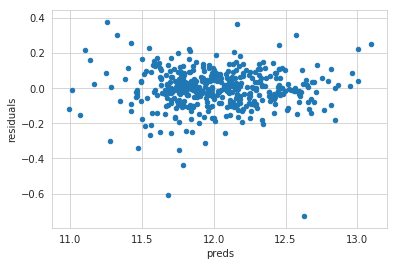

In [81]:
preds = pd.DataFrame({"preds":GBoost.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

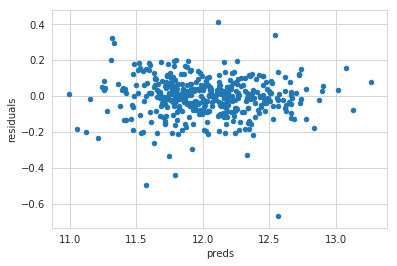

In [82]:
preds = pd.DataFrame({"preds":ENet.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

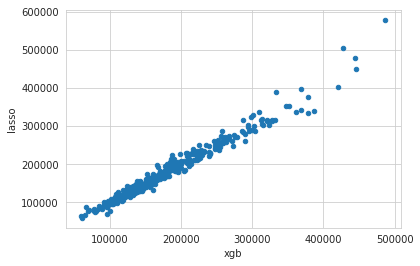

In [79]:
xgb_preds = np.expm1(GBoost.predict(X_test))
lasso_preds = np.expm1(ENet.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

## 集成学习(模型融合)

Stacking models 是指通过将多个模型进行集成以取得更小预测方差的方法, 通过前面的两个模型残差图的分布可以发现具有一定的互补性，所以这才是融合的目的，将他的残差分布变得更均匀。

**平均模型**

In [83]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [85]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1081 (0.0056)



**堆叠模型(Stacking Averaged Models)**

其由两部分组成，一部分是基准模型，一部分是回归模型：

基准模型和大量数据组合预测一堆结果，然后根据预测结果通过回归模型预测和真实值的差异。具体如下：

![](./images/QBuDOjs.jpg)

![](https://img-blog.csdn.net/20171117094740886?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvcXFfMTg5MTYzMTE=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/Center)

In [87]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model) # 复制基准模型，因为这里会有多个模型
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # 训练基准模型，基于基准模型训练的结果导出成特征
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y): #分为预测和训练
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 将基准模型预测数据作为特征用来给meta_model训练
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [93]:
meta_model = Lasso(alpha = 0.00001, random_state=1)
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, lasso),
                                                 meta_model = meta_model)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/home/shikanon/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/shikanon/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/shikanon/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/shikanon/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/coordinate_

Stacking Averaged models score: 0.1084 (0.0063)


/home/shikanon/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## 参考资料

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/jolasa/eda-anda-data-preparation-7th-place

https://www.kaggle.com/apapiu/regularized-linear-models